<a href="https://colab.research.google.com/github/mrrkdas/LazyProgrammer-DeepLearning-Course/blob/main/Resnet_with_Fruits_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools

## Getting to know the data

In [2]:
img_size = [100, 100] 

epochs = 5
batch_size = 128 

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/fruits-360.zip

--2022-04-08 18:59:26--  https://lazyprogrammer.me/course_files/fruits-360.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M  11.6MB/s    in 13s     

2022-04-08 18:59:39 (14.1 MB/s) - ‘fruits-360.zip’ saved [190820824/190820824]



In [4]:
!unzip -nq fruits-360.zip

In [5]:
train_path = 'fruits-360/Training'
valid_path = 'fruits-360/Validation'

In [6]:
# For getting the number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [7]:
# For getting the number of classes
folders = glob(train_path + '/*')

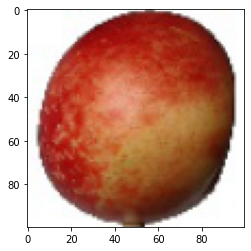

In [8]:
plt.imshow(image.load_img(np.random.choice(image_files)));

## Model

In [9]:
res = ResNet50(input_shape = (img_size + [3]), weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [10]:
for layer in res.layers:
  layer.trainable = False

In [11]:
x = Flatten() (res.output)

output = Dense(len(folders), activation='softmax') (x)

In [12]:
model = Model(inputs = res.input, outputs = output)

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Preprocessing the data and fitting the data



In [14]:
# Generators to augment the images
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [15]:
test_gen = val_gen.flow_from_directory(valid_path, target_size= img_size)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 9673 images belonging to 60 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Carambula': 16, 'Cherry': 17, 'Clementine': 18, 'Cocos': 19, 'Dates': 20, 'Granadilla': 21, 'Grape Pink': 22, 'Grape White': 23, 'Grape White 2': 24, 'Grapefruit Pink': 25, 'Grapefruit White': 26, 'Guava': 27, 'Huckleberry': 28, 'Kaki': 29, 'Kiwi': 30, 'Kumquats': 31, 'Lemon': 32, 'Lemon Meyer': 33, 'Limes': 34, 'Litchi': 35, 'Mandarine': 36, 'Mango': 37, 'Maracuja': 38, 'Nectarine': 39, 'Orange': 40, 'Papaya': 41, 'Passion Fruit': 42, 'Peach': 43, 'Peach Flat': 44, 'Pear': 45, 'Pear Abate': 46, 'Pear Monster': 47, 'Pear Williams': 48, 'Pepino': 49, 'Pineapple': 50, 'Pitahaya Red': 51, 'Plum': 52, 'Pomegranate': 53, 'Quince': 54, 'Ra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -114.68 max: 151.061


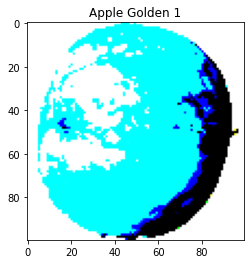

In [16]:
# Color will be weird because the VGG weights are in BGR
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [17]:
# Create the generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size= img_size,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size= img_size,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


In [18]:
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size, validation_steps=len(valid_image_files) // batch_size)

Epoch 1/5
224/224 [==============================] - 143s 566ms/step - loss: 0.6172 - accuracy: 0.9187 - val_loss: 0.1878 - val_accuracy: 0.9643
Epoch 2/5
224/224 [==============================] - 130s 579ms/step - loss: 0.1480 - accuracy: 0.9755 - val_loss: 0.3294 - val_accuracy: 0.9644
Epoch 3/5
224/224 [==============================] - 128s 571ms/step - loss: 0.1237 - accuracy: 0.9822 - val_loss: 0.2581 - val_accuracy: 0.9691
Epoch 4/5
224/224 [==============================] - 123s 549ms/step - loss: 0.1005 - accuracy: 0.9856 - val_loss: 0.0928 - val_accuracy: 0.9832
Epoch 5/5
224/224 [==============================] - 123s 549ms/step - loss: 0.0918 - accuracy: 0.9891 - val_loss: 0.4986 - val_accuracy: 0.9648


## After Model

In [19]:
def plot_metrics(history, accuracy = 'accuracy', validation_accuracy = 'val_accuracy'):
  """ Plots loss, and accuracy. 

  Parameter:

    history: model.fit()
    accuracy: the type of accuracy (could vary for sum situations)
    validation_accuracy: type of validation accuracy (could vary for some situations) """

  plt.plot(history.history['loss'], label = "Loss")
  plt.plot(history.history['val_loss'], label = 'Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Vs. Epochs')
  plt.legend()
  plt.show()

  plt.plot(history.history[accuracy], label = "Accuracy")
  plt.plot(history.history[validation_accuracy], label = 'Validation Accuracy')
  plt.xlabel('Epcohs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Vs. Epochs')
  plt.legend()
  plt.show()

In [22]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  n_images = 0
  for x, y in val_gen.flow_from_directory(
      data_path,
      target_size= img_size,
      shuffle=False,
      batch_size=batch_size * 2):
    i += 1
    n_images += len(y)
    if i % 50 == 0:
      print(f'{n_images} images processed.')
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [23]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 28736
Found 28736 images belonging to 60 classes.
12800 images processed.
25600 images processed.
[[492   0   0 ...   0   0   0]
 [  0 480   0 ...   0   0   0]
 [  0   0 381 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 490   0]
 [  0   0   0 ...   0   0 490]]


In [24]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 9673
Found 9673 images belonging to 60 classes.
[[164   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0  96 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 166]]


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.figure(figsize=(15, 15))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[492   0   0 ...   0   0   0]
 [  0 480   0 ...   0   0   0]
 [  0   0 381 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 490   0]
 [  0   0   0 ...   0   0 490]]


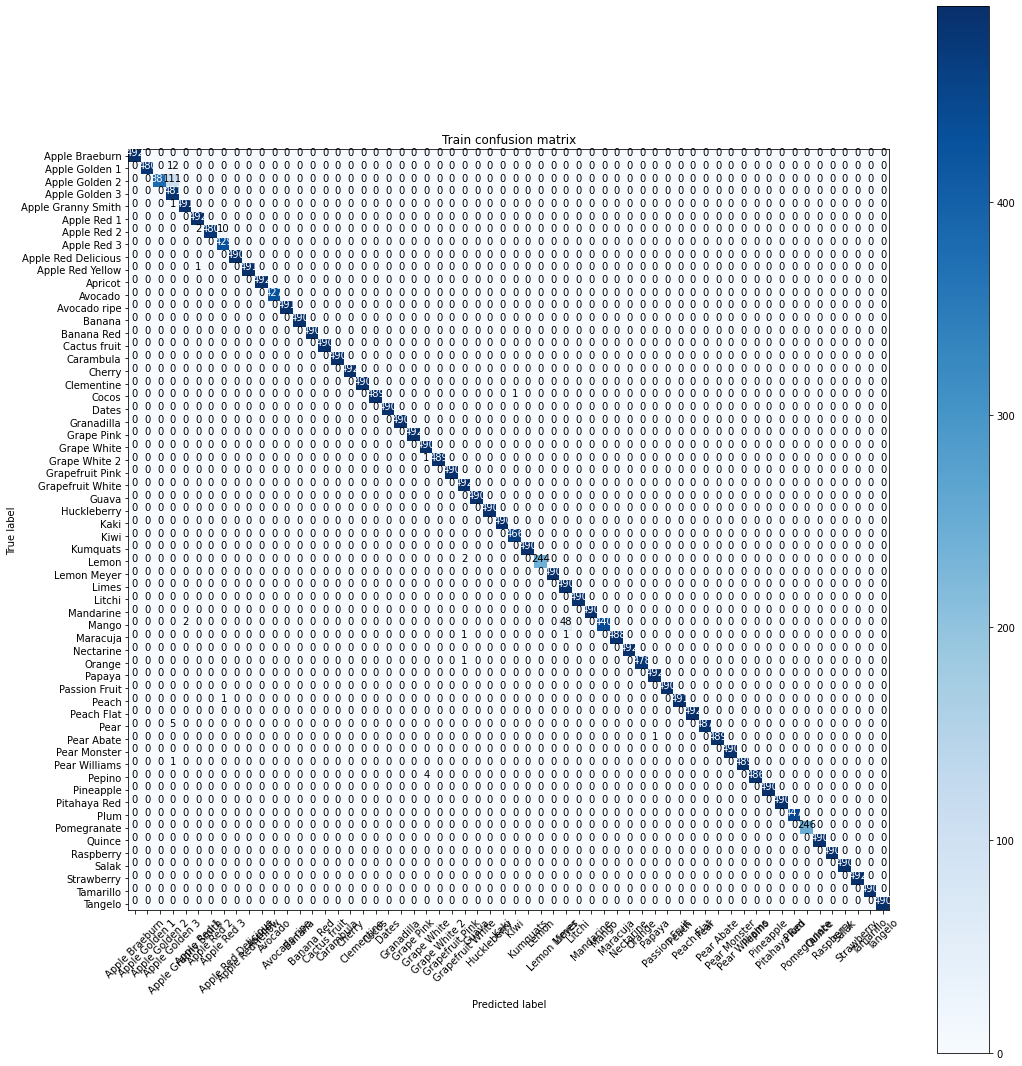

In [26]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

Confusion matrix, without normalization
[[164   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0  96 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 166]]


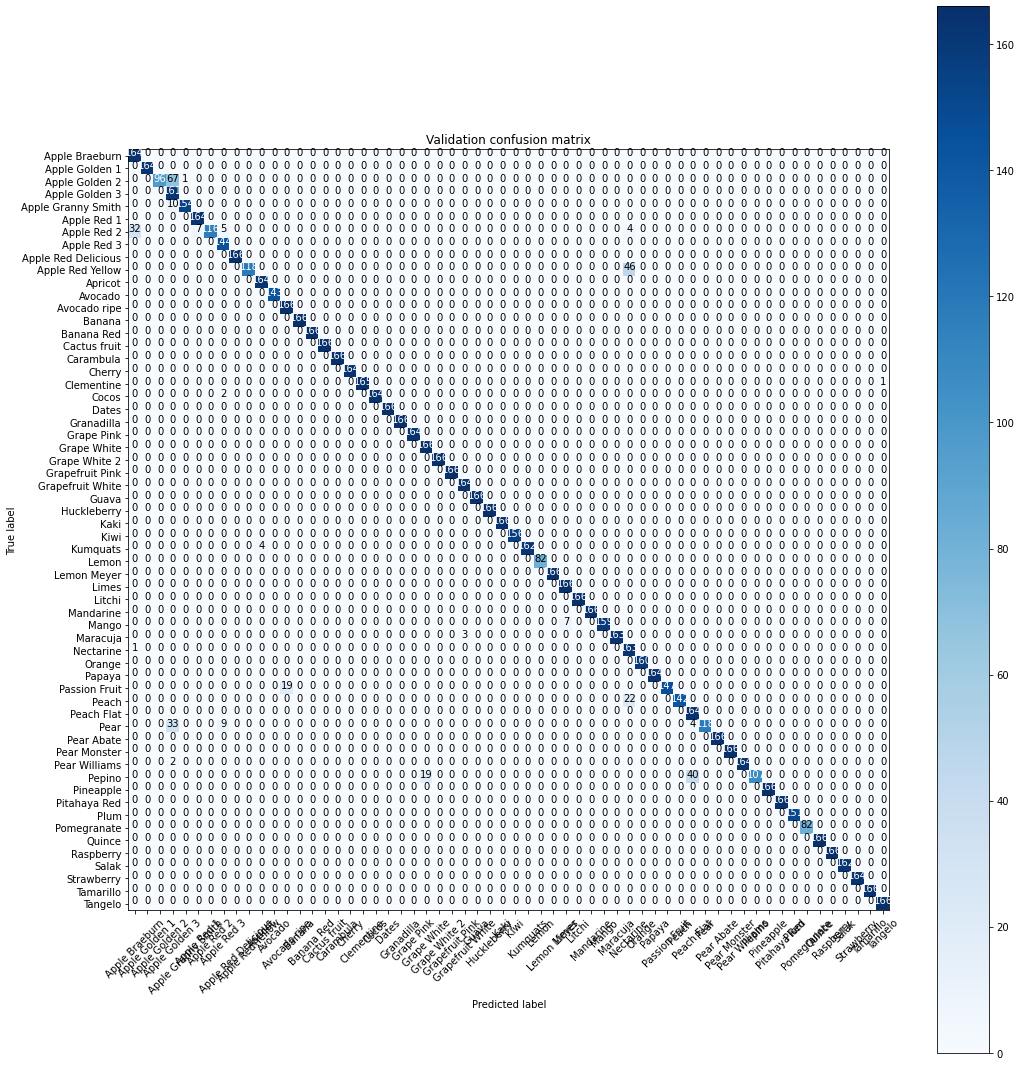

In [27]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')